<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/Cross_Correaltion_Hailisu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pingouin

In [23]:
from pingouin import *

import warnings
warnings.filterwarnings("ignore")


# Importing packages


In [24]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
data preparation
We generate the first 3 main principal components that capture the most useful information of the data. P1, P2 and P3 are not correalted with each other while they are epressed as the linear cominination of the available featurdes, i.e. ET0, VPD, Rn and T (air temperature)

**Note:** Make sure that the data file is addressed correctly and it's already avaialble in your Google drive.

In [28]:

# dataFile = 'Changde.xlsx'  
dataFile = 'Hailisu.xlsx'  
# dataFile = 'Lancang.xlsx'  
# dataFile = 'Miyun.xlsx'  
# dataFile = 'Nanmulin.xlsx'  
# dataFile = 'Qiemo.xlsx'

data = pd.read_excel('/content/drive/My Drive/'+ dataFile)

In [29]:
# revising the column names
for col in data.columns:
  newcol = col.split("(")[0].strip()
  data.rename(columns={col:newcol}, inplace=True)

# setting up the index of the data frame
data.set_index("TIMESTAMP", inplace=True)

# resample data daily, forward linear interpolation to fill the missing values
data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

## Optional:
## Generating the first three principal (P1, P2, P3) components basesd on ET0, VPD, Rn and T.
myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(myData)
pca_data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
data["P1"] = pca_data[:,0]
data["P2"] = pca_data[:,1]
data["P3"] = pca_data[:,3]

data["TA_max-TA_min"] = data["TA_max"] - data["TA_min"]

# displaying the first couple rows of the data table
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3,TA_max-TA_min
TIMESTAMP,,,,,,,,,,,,,,,,
1990-01-01,1,4.5,-15.9,1.4,74.0,-20.3,-10.8,2.194157,0.049189,0.014773,0.067364,0.353247,-2.604686,0.219401,0.051999,9.5
1990-01-02,2,6.3,-14.7,1.2,55.0,-21.6,-7.2,2.455747,0.098182,0.016148,0.067364,0.708336,-2.433856,0.237608,0.013234,14.4
1990-01-03,3,6.5,-10.5,1.8,63.0,-15.0,-5.6,2.851274,0.105714,0.021875,0.067364,0.773378,-2.218240,0.177261,0.023540,9.4
1990-01-04,4,6.8,-14.6,1.4,71.0,-18.5,-8.6,2.698292,0.057183,0.016267,0.067364,0.455943,-2.477608,0.140149,0.051026,9.9
1990-01-05,5,5.8,-15.2,1.1,55.0,-22.2,-5.9,2.000768,0.090000,0.015562,0.067364,0.627822,-2.522159,0.310003,0.011304,16.3


# Data Exploration

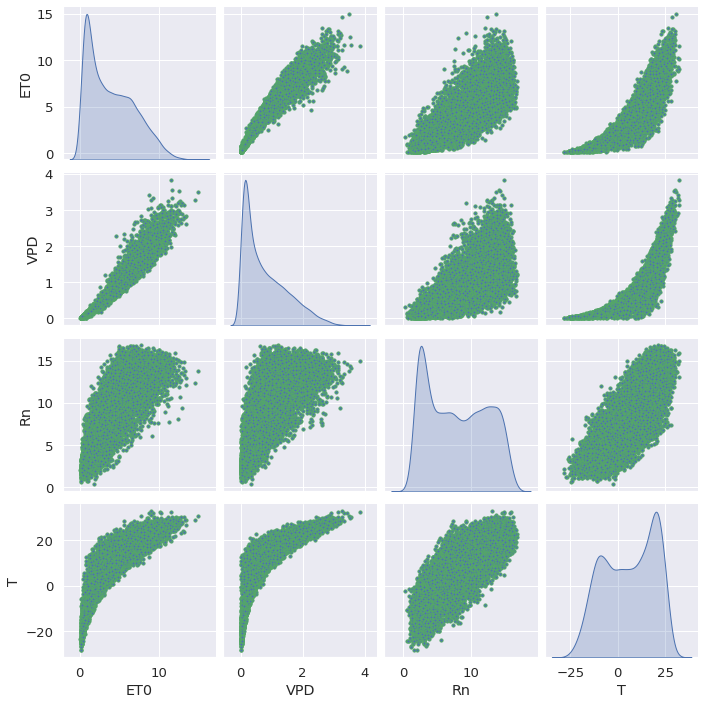

In [30]:
import seaborn as sns
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.2)
pp = sns.pairplot(data[["ET0", "VPD", "Rn", "T"]].dropna(), diag_kind="kde", markers=".", plot_kws=dict(s=40, edgecolor="g", linewidth=1),diag_kws=dict(shade=True))

# Looking at features mutual correlations

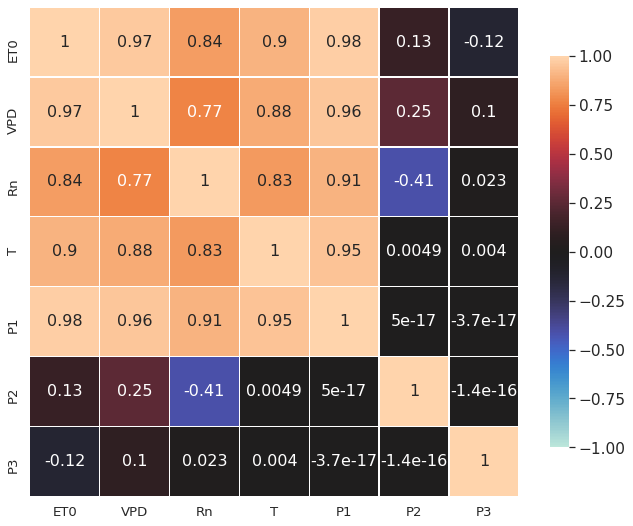

In [31]:
corr = data[["ET0", "VPD", "Rn", "T", "P1", "P2", "P3"]].dropna().corr()

### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.4)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 16}, annot=True) # , mask=mask)

# Staging some data for ML modeling


Generating train and test data sets.
For the sake of speed, we use use a fraction of data for evaluation of our algorithm. Later to get the final results, we use the entire data set.

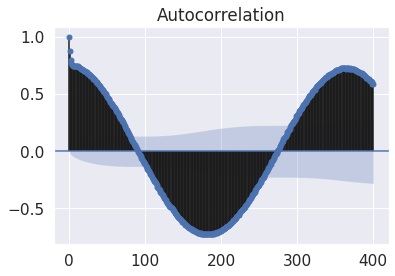

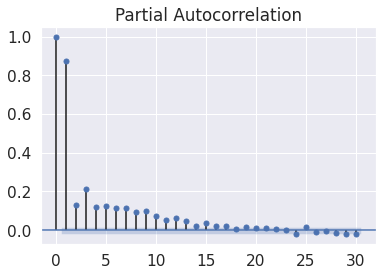

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = data["ET0"].ffill().bfill()

plot_acf(y, lags=400)
plt.show()

plot_pacf(y, lags=30)
plt.show()

In [33]:
data.columns

Index(['DOY', 'U', 'T', 'ea（hpa）', 'RH', 'TA_min', 'TA_max', 'Rn', 'VPD',
       'Delta', 'gamma', 'ET0', 'P1', 'P2', 'P3', 'TA_max-TA_min'],
      dtype='object')

Text(0.5, 0, 'Lag (day)')

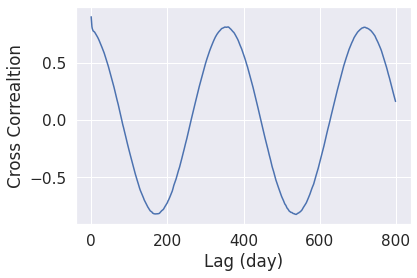

In [34]:
import statsmodels.tsa.stattools as stattools

plt.plot(stattools.ccf(data["ET0"], data["T"])[:800])
plt.ylabel("Cross Correaltion")
plt.xlabel("Lag (day)")

In [35]:
# corr = partial_corr(data=data, x='ET0', y='T', covar=[], method='pearson')
# corr

### How to generate partial correaltion functions

In [36]:
def pccf_(dataFrame, xx, yy, lag=1):

  df = dataFrame[[xx, yy]]
  cols = []

  for i in range(lag):
    col = 'z'+str(i)
    cols.append(col)
    df[col] = df[yy].shift(i+1, 'D')

  df = df.iloc[lag:]
  corr = partial_corr(data=df, x=xx, y=cols[lag-1], covar=cols[:-1], method='pearson')

  C = corr['r'].pearson
  CI95 = corr["CI95%"].pearson

  return C, CI95[0], CI95[1]

#################################################

def pccf(dataFrame, xx, yy, lag=1):
  PCC = [] 
  CI1 = []
  CI2 = []
  for l in range(1,lag):
    PCC_, CI1_, CI2_ = pccf_(dataFrame, xx, yy, lag=l)
    PCC.append(PCC_)
    CI1.append(CI1_)
    CI2.append(CI2_)
  return PCC, CI1, CI2

In [45]:
def plot_pcc(dataFrame, xx, yy, margincolor='red'):
  # xx = 'ET0'
  # yy = 'VPD'

  PCC, CI1, CI2 = pccf(dataFrame, xx, yy, lag=50)

  N = len(PCC)

  plt.plot(PCC)
  plt.fill_between(range(N), CI1, CI2, color=margincolor, alpha=0.2)

  plt.ylabel("Partial Cross Correaltion")
  plt.xlabel("Lag (day)")
  plt.title("Hailisu ("+ xx + " & " + yy + ")")

  plt.show()

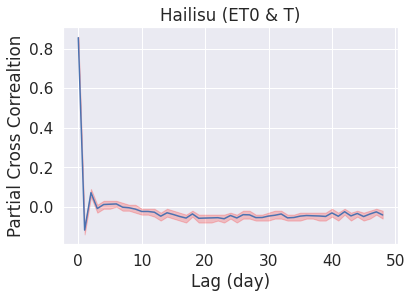

In [46]:
plot_pcc(data, "ET0", "T")

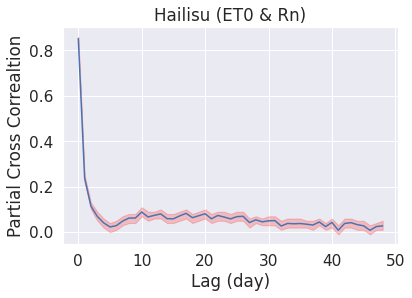

In [47]:
plot_pcc(data, "ET0", "Rn")

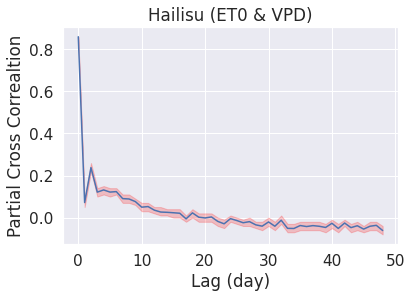

In [48]:
plot_pcc(data, "ET0", "VPD")

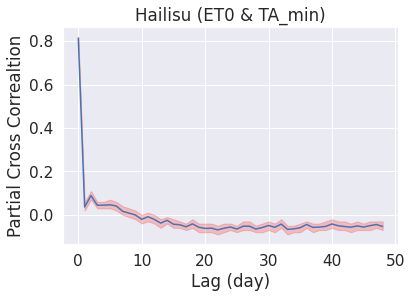

In [49]:
plot_pcc(data, "ET0", "TA_min")

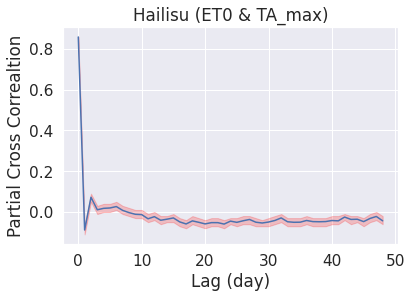

In [50]:
plot_pcc(data, "ET0", "TA_max")

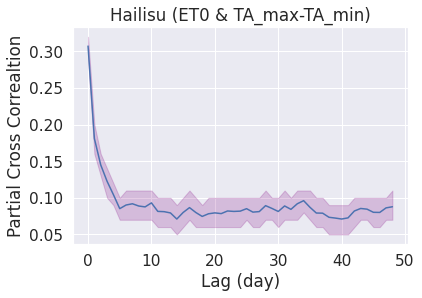

In [51]:
plot_pcc(data, "ET0", "TA_max-TA_min", margincolor='purple')

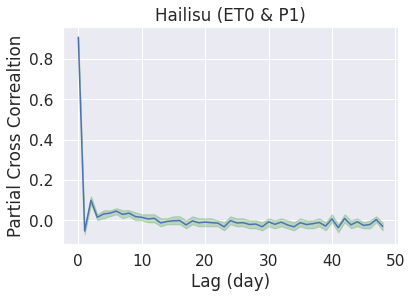

In [52]:
plot_pcc(data, "ET0", "P1", margincolor='green')